## Improving the Model

The model as it stands does not have high recall or precision. A 40% reduction in dropouts may be extremely valuable to a school district, however, the model at best predicts which students are more likely to dropout. There is no evidence from the data itself that there is a particular strategy that will cause a dropout case to shift to a non-dropout case. This would be the focus of additional work.

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
#Load Features, labels, and weights from Baseline Model
import pickle
filepath = '/Users/chrismalec/DS_Portfolio/CapstoneProjectOne/'

X = np.load(filepath+'X.npy')
y = np.load(filepath+'y.npy')
weight = np.load(filepath+'weight.npy')
pickle_in = open(filepath+'feature_names.pkl',"rb")
feature_names = pickle.load(pickle_in)

pickle_in = open(filepath+'labels.pkl',"rb")
labels = pickle.load(pickle_in)
y = np.array(labels)

#Delete any non-response variables
i, = np.where((y == 1) | (y == 0))
y = y[i]
X = X[i,:]
weight = weight[i]

#Break into train/test/validate sets
n_obs = X.shape[0]
n_train = round(0.6*n_obs)
n_test = round(0.2*n_obs)

shuffle_index = np.random.choice(range(len(y)), size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:(n_train+n_test)]
val_index = shuffle_index[(n_train+n_test):]

X_train = X[train_index,:]
y_train = y[train_index]
weight_train = weight[train_index]

X_test = X[test_index,:]
y_test = y[test_index]

X_val = X[val_index,:]
y_val = y[val_index]

### Class Weight
One method is to adjust the 'class weight' parameter in sklearn's LogisticRegression model. The balanced mode creates a weight that is inversely proportional to the frequency of each class. Therefore the minority class gets weighted more than the majority class.

The resulting precision and recall is somewhat improved from the baseline, capturing 54% of dropout cases, but a lower precision.

In [4]:
class_weight_model = LogisticRegression(solver = 'liblinear', C = 1e-2, penalty = 'l1',class_weight = 'balanced')
class_weight_model.fit(X_train,
                       y_train,
                       sample_weight = weight_train
                      )
y_predict = class_weight_model.predict(X_test)

print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))

              precision    recall  f1-score   support

 Non-Dropout       0.93      0.85      0.89      4192
     Dropout       0.28      0.47      0.35       509

   micro avg       0.81      0.81      0.81      4701
   macro avg       0.60      0.66      0.62      4701
weighted avg       0.86      0.81      0.83      4701



### Shift the Cutoff or Precision-Recall Curves

Another option is to shift where the algorithm places the cut-off for membership in the 'dropout class' is. The predict method of the logistic regression model assumes that if the probability is greater than 50%, then the observation is in the dropout class. However, since there are so many more non-dropout cases, this cutoff may be overly conservative. By predicting probabilities and manually selecting the cutoff, we can perhaps find a better cutoff that improves precision and recall.

This amounts to creating a precision-recall curve. It plots the possibly combinations of precision and recall for a model by creating different probability cutoffs for predicting a dropout case.

An ROC curve can also be drawn. This merely replaces Precision with the True Positive Rate, since Recall is the same as False Positive Rate.

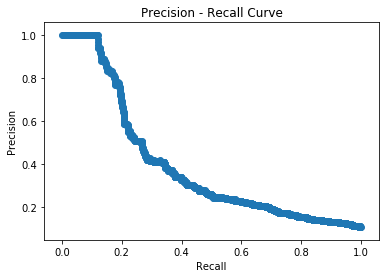

In [5]:
from sklearn.metrics import precision_recall_curve, roc_curve

y_probs = class_weight_model.predict_proba(X_test)[:,1]
precision, recall,thresholds = precision_recall_curve(y_test,y_probs)
plt.scatter(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.show()

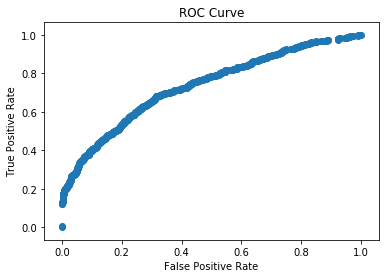

In [6]:
#We can also make an ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.scatter(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

We can see from the precision-recall curve that there is no cutoff that provides both high precision and recall in this model. We can also see clearly from the ROC curve that our model is in fact performing better than guessing, since it is entirely above the line where the True Positive and False Positive rates are the same. Therefore we should try another method, undersampling.

### Undersampling

The package imblearn contains useful tools for dealing with data imbalance. Here, we use the RandomUnderSampler object to under-sample, or randomly remove observations from the majority class.

              precision    recall  f1-score   support

 Non-Dropout       0.94      0.70      0.80      4192
     Dropout       0.20      0.62      0.30       509

   micro avg       0.69      0.69      0.69      4701
   macro avg       0.57      0.66      0.55      4701
weighted avg       0.86      0.69      0.75      4701



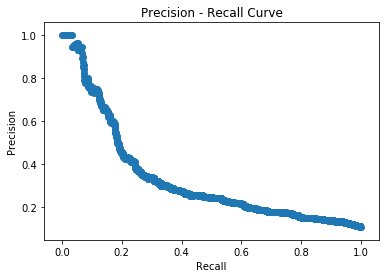

In [7]:
#Use undersampling object from imbalanced learn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
model = LogisticRegression(solver = 'liblinear', C = 1e-2, penalty = 'l1')
model.fit(X_resampled,
             y_resampled,
             sample_weight = weight_train[rus.sample_indices_]
             )
y_predict = model.predict(X_test)
print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))
y_probs = model.predict_proba(X_test)[:,1]
precision, recall,thresholds = precision_recall_curve(y_test,y_probs)
plt.scatter(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.show()

The recall is significantly higher, nearly 70%, and the precision drops a bit. We need to be careful, because eventually the recall can be made very high merely by guessing that everyone is a dropout. In this case the precision would be the proportion of students who actually drop out. 

So undersampling isn't a magic bullet, maybe oversampling is?

              precision    recall  f1-score   support

 Non-Dropout       0.93      0.87      0.90      4192
     Dropout       0.30      0.45      0.36       509

   micro avg       0.82      0.82      0.82      4701
   macro avg       0.61      0.66      0.63      4701
weighted avg       0.86      0.82      0.84      4701



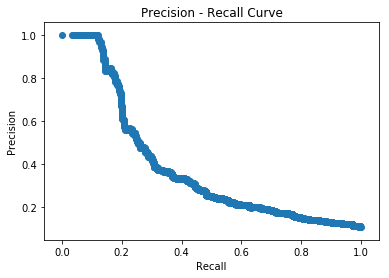

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
model = LogisticRegression(solver = 'liblinear', C = 1e-2, penalty = 'l1')
model.fit(X_resampled,
             y_resampled,
             sample_weight = weight_train[ros.sample_indices_]
             )
y_predict = model.predict(X_test)
print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))
y_probs = model.predict_proba(X_test)[:,1]
precision, recall,thresholds = precision_recall_curve(y_test,y_probs)
plt.scatter(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.show()

## Change the score function
We have a better balance between recall and precision, but there seems to be only so much precision we can get this way. We therefore, we try to optimize for a different measure. Before we used some plots to take a guess at a balance between recall and precision. Here, we explicitly optimize for the f1 score, which is an intermediate value to the recall and precision.

In [9]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver = 'liblinear')

parameters = {'penalty':('l1','l2'),
              'C':np.geomspace(1e-4,.1,4)
             }

clf = GridSearchCV(estimator = model, 
                   param_grid = parameters, 
                   scoring = 'f1',
                   cv = 5
                  )
clf.fit(X_train,
        y_train,
        sample_weight = weight_train
       )

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': array([0.0001, 0.001 , 0.01  , 0.1   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4192
           1       0.56      0.29      0.38       509

   micro avg       0.90      0.90      0.90      4701
   macro avg       0.74      0.63      0.66      4701
weighted avg       0.88      0.90      0.88      4701



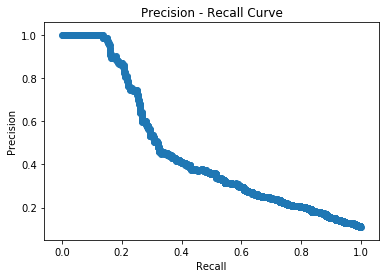

In [10]:
print(clf.best_estimator_)
model_best = clf.best_estimator_
y_prob = model_best.predict_proba(X_test)[:,1]
y_pred = model_best.predict(X_test)
print(classification_report(y_test,y_pred))
precision, recall,thresholds = precision_recall_curve(y_test,y_prob)
plt.scatter(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.show()

Now we've lost a lot of recall again, let's try to combine a couple methods. Oversampling honestly did about the same as classweights, except classweights is much faster.

In [11]:
model = LogisticRegression(solver = 'liblinear',class_weight='balanced')

parameters = {'penalty':('l1','l2'),
              'C':np.geomspace(1e-4,.1,4)
             }

clf = GridSearchCV(estimator = model, 
                   param_grid = parameters, 
                   scoring = 'f1',
                   cv = 5
                  )
clf.fit(X_train,
        y_train,
        sample_weight = weight_train
       )

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': array([0.0001, 0.001 , 0.01  , 0.1   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4192
           1       0.27      0.69      0.39       509

   micro avg       0.77      0.77      0.77      4701
   macro avg       0.61      0.73      0.62      4701
weighted avg       0.88      0.77      0.80      4701



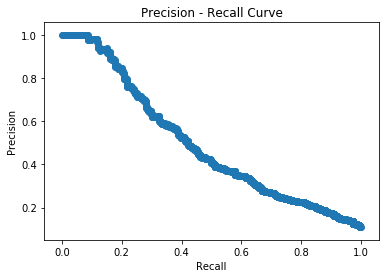

In [12]:
print(clf.best_estimator_)
model_best = clf.best_estimator_
y_prob = model_best.predict_proba(X_test)[:,1]
y_pred = model_best.predict(X_test)
print(classification_report(y_test,y_pred))
precision, recall,thresholds = precision_recall_curve(y_test,y_prob)
plt.scatter(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.show()

This is the best of both worlds, and may perhaps be improved by more careful parameter selection. What would be really nice, is the ability to actually choose between models with high precision and models with high recall.

The fbeta score allows us to do exactly this. It is a weighted average between precision and recall, so we can choose the levels that work best for a particular application.

In [28]:
models = []

parameters = {'penalty':('l1','l2'),
              'C':np.geomspace(1e-4,1,10)
             }

model = LogisticRegression(solver = 'liblinear',class_weight='balanced')

for penalty in parameters['penalty']:
    for C in parameters['C']:
        models.append(LogisticRegression(solver = 'liblinear',class_weight='balanced',C=C,penalty=penalty))
        models[-1].fit(X_train,y_train,sample_weight = weight_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [169]:
#generate some models with a lower recall and higher precision
for penalty in parameters['penalty']:
    for C in parameters['C']:
        models.append(LogisticRegression(solver = 'liblinear',C=C,penalty=penalty))
        models[-1].fit(X_train,y_train,sample_weight = weight_train)

In [190]:
from sklearn.metrics import fbeta_score
betas = np.linspace(0.1,2,20)

df_beta = pd.DataFrame(data={'beta':[],
                             'fbeta':[],
                             'C':[],
                             'penalty':[],
                             'precision':[],
                             'recall':[]
                            })

for model in models:
    for beta in betas:
        y_pred = model.predict(X_test)
        fbetascore = fbeta_score(y_test,y_pred,beta = beta)
        C = model.get_params()['C']
        penalty = model.get_params()['penalty']
        report = classification_report(y_test,y_pred,output_dict = True)
        precision = report['1']['precision']
        recall = report['1']['recall']
    
        df_beta = df_beta.append(pd.DataFrame([[beta,fbetascore,C,penalty,precision,recall]],
                                          columns = df_beta.columns),
                                          ignore_index=False)
    

In [177]:
import pickle
f = open(filepath+'models.pkl','wb')
pickle.dump(models,f)
f.close()

In [191]:
df_agg = df_beta.sort_values(['beta','fbeta'],ascending=False).groupby('beta').head(3)

In [196]:
df_agg

,beta,fbeta,C,penalty,precision,recall
0,2.0,0.527894,0.000100,l1,0.271186,0.691552
0,2.0,0.495003,0.000278,l1,0.271870,0.622790
0,2.0,0.463951,0.000774,l1,0.271523,0.563851
0,1.9,0.517533,0.000100,l1,0.271186,0.691552
0,1.9,0.486557,0.000278,l1,0.271870,0.622790
0,1.9,0.457100,0.000774,l1,0.271523,0.563851
0,1.8,0.506413,0.000100,l1,0.271186,0.691552
0,1.8,0.477444,0.000278,l1,0.271870,0.622790
0,1.8,0.449670,0.000774,l1,0.271523,0.563851
0,1.7,0.494502,0.000100,l1,0.271186,0.691552


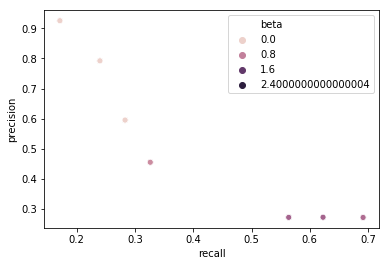

In [195]:
import seaborn as sns
sns.scatterplot(x='recall',y='precision',hue = 'beta',data=df_agg)
plt.show()

We can clearly see that the higher we set beta, the more recall is weighted in our model selection. In this way we can select models with various trade-offs of precision and recall. Though there does appear to be a curve on which most of our models fall. Pushing beyond this curve would be the goal of future work.